# Example: Parameter Uncertainty in Single Index Models (SIMs)
In this example, students will explore the question of parameter uncertainty in single index models. Single index models are widely used in finance to model the growth rate (return) of assets based on firm-specific factors and their relationship with a market index.

> __Learning Objectives:__
>
> Fill me in

Let's go!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for several exchange-traded funds and volatility products during that time period. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"]; # original dataset

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Finally, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [6]:
Δt = (1.0/252.0); # time step

___

## Task 1: Estimate Single Index Models for All Firms in our Dataset
In this task, we'll estimate single index models for all firms in our dataset, including the 95% confidence intervals for the parameters. We'll use the `SPY` ETF as our market index.

Let's start by computing the growth rate matrix for all firms in the dataset. We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned dataset and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array.

We'll save this data in the `growth_rate_array::Array{Float64,2}` variable:"

In [7]:
growth_rate_array = let

    # initialize -
    r̄ = 0.0; # assume the risk-free rate is 0

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = Δt, 
        risk_free_rate = r̄); # other optional parameters are at their defaults

    growth_rate_array; # return
end

2766×424 Matrix{Float64}:
 -0.877554    6.28105    -2.87097     …  -0.755391   0.245894  -1.00527
  2.81626     1.07149     1.39239         2.13832   -0.80279    0.986468
  3.31305     0.855597    0.00536803      0.109877   1.191     -2.58144
  0.646425   17.2599      1.69215         0.274716   3.1593    -0.368228
  1.81609     2.57961     3.31924         0.621677  -2.1687     4.40309
  0.61383    -3.96384    -0.79278     …  -0.862739  -1.90977   -3.11624
  2.86071    -0.483751    4.84573         1.7657    -1.77685   -1.0896
  2.04671     1.0135      1.90809         1.67597    4.44984   -0.137819
  1.31289     1.67413     0.107259       -1.50708   -2.13696    1.43784
  1.22016     6.12957     0.932578       -1.53202    2.87784   -1.43626
  ⋮                                   ⋱                        
 -4.36889     3.84443    -2.37452        -4.26011   -9.17906   -3.94641
 -2.51182    -2.60891   -10.1209         -3.03895   -7.07468   -7.14019
  2.21355     4.15066     7.27678         3.

Next, we need to pull out the excess growth (return) of the market portfolio from `growth_rate_array::Array{Float64,2}`. To do this, look up the index for our market portfolio surrogate `SPY`, then store the growth rate (column from the growth rate array) in the `Rₘ::Array{Float64,1}` variable:

In [8]:
Gₘ = findfirst(x->x=="SPY", list_of_tickers) |> i -> growth_rate_array[:,i];

Fill me in.

In [ ]:
parameters_theory_dict = let

    # initialize -
    T = maximum_number_trading_days - 1; # number of time steps
    X̂ = [ones(T) Gₘ];
    p = 2; # number of parameters
    n = T; # number of training observations
    Δt  = (1/252); # time-step one-day in units of years (trading year is 252 days)
    t = 1.96; # for a 95% confidence interval
    data = Dict{String, NamedTuple}(); # dictionary to hold results

    for i ∈ eachindex(list_of_tickers)

        ticker = list_of_tickers[i]; # current ticker symbol
        yᵢ = findfirst(x-> x== ticker, list_of_tickers) |> j-> growth_rate_array[:, j];  # get the growth values for ticker
        θ̂ᵢ = inv(transpose(X̂) * X̂) * transpose(X̂) * yᵢ; # compute the SIM parameters for ticker
        rᵢ = yᵢ .- X̂*θ̂ᵢ; # residual vector
        my_training_variance = (1/Δt)*(1/(n-p))*norm(rᵢ)^2; # training variance
        SEᵢ = sqrt.(diag(inv(transpose(X̂)*X̂))*my_training_variance*Δt);  # compute the standard error

        # save the results in a named tuple
        dtp = ( 
            ticker = ticker,
            n = n,
            p = p,
            t = t,
            alpha = θ̂ᵢ[1], 
            beta = θ̂ᵢ[2], 
            alpha_SE = SEᵢ[1], 
            beta_SE = SEᵢ[2], 
            alpha_95_CI_lower = θ̂ᵢ[1] - t*SEᵢ[1], 
            alpha_95_CI_upper = θ̂ᵢ[1] + t*SEᵢ[1], 
            beta_95_CI_lower = θ̂ᵢ[2] - t*SEᵢ[2], 
            beta_95_CI_upper = θ̂ᵢ[2] + t*SEᵢ[2], 
            training_variance = my_training_variance
        );
        data[ticker] = dtp; # save the named tuple in the dictionary
    end

    # return the data dictionary
    data;
end

Dict{String, NamedTuple} with 424 entries:
  "EMR"  => (ticker = "EMR", n = 2766, p = 2, t = 1.96, alpha = -0.0766521, bet…
  "CTAS" => (ticker = "CTAS", n = 2766, p = 2, t = 1.96, alpha = 0.109836, beta…
  "HSIC" => (ticker = "HSIC", n = 2766, p = 2, t = 1.96, alpha = -0.0548436, be…
  "KIM"  => (ticker = "KIM", n = 2766, p = 2, t = 1.96, alpha = -0.106516, beta…
  "PLD"  => (ticker = "PLD", n = 2766, p = 2, t = 1.96, alpha = -0.0106119, bet…
  "IEX"  => (ticker = "IEX", n = 2766, p = 2, t = 1.96, alpha = -0.00855943, be…
  "BAC"  => (ticker = "BAC", n = 2766, p = 2, t = 1.96, alpha = -0.0545152, bet…
  "CBOE" => (ticker = "CBOE", n = 2766, p = 2, t = 1.96, alpha = 0.0671482, bet…
  "EXR"  => (ticker = "EXR", n = 2766, p = 2, t = 1.96, alpha = 0.0425355, beta…
  "NCLH" => (ticker = "NCLH", n = 2766, p = 2, t = 1.96, alpha = -0.251454, bet…
  "CVS"  => (ticker = "CVS", n = 2766, p = 2, t = 1.96, alpha = -0.123485, beta…
  "DRI"  => (ticker = "DRI", n = 2766, p = 2, t = 1.96, alpha = -0

What's in the `parameters_theory::Dict{String, NamedTuple}` variable? Let's take a look:

In [12]:
parameters_theory_dict["PG"] # look at the results for Microsoft

(ticker = "PG", n = 2766, p = 2, t = 1.96, alpha = 0.014676312973311125, beta = 0.49051042376920384, alpha_SE = 0.0422195602563985, beta_SE = 0.01966250116372708, alpha_95_CI_lower = -0.06807402512922994, alpha_95_CI_upper = 0.09742665107585219, beta_95_CI_lower = 0.4519719214882988, beta_95_CI_upper = 0.5290489260501089, training_variance = 1795.1914051896401)

__Ok, wow!__ We have the $\alpha$ and $\beta$ parameters for each firm, along with their 95% confidence intervals. Let's explore the performance of our single index model for some specific firms, and validate that the confidence intervals make sense.
___

## Task 2: Compute R-Squared Values for Each Firm's SIM
In this task, we'll compute the R-squared values for each firm's single index model (SIM) to assess the goodness of fit. The R-squared value indicates how well the model explains the variability of the response data around its mean.

First, specify a ticker symbol for a firm of interest. For this example, let's use `PG` (Procter & Gamble) (but you can choose any firm from the `list_of_tickers` array):

In [43]:
ticker_of_interest = "GS"; # Apple Inc. (you can choose any ticker from list_of_tickers)

Next, let's compute the R-squared value for the specified firm:

In [44]:
RS = let 
    
    # initialize -
    parameters = parameters_theory_dict[ticker_of_interest]; # get the parameters for the ticker of interest
    i = findfirst(x-> x== ticker_of_interest, list_of_tickers);  # index of the ticker of interest
    yᵢ = growth_rate_array[:, i];  # get the growth values for ticker
    T = length(yᵢ); # number of time steps
    X̂ = [ones(T) Gₘ]; # design matrix
    θ̂ᵢ = [parameters.alpha; parameters.beta]; # parameter estimates
    ŷᵢ = X̂ * θ̂ᵢ; # predicted values
    SS_total = sum((yᵢ .- mean(yᵢ)).^2); # total sum of squares
    SS_residual = sum((yᵢ .- ŷᵢ).^2); # residual sum of squares
    R_squared = 1 - (SS_residual / SS_total); # R-squared value

    R_squared; # return
end

0.5195545179144796

Fill me in

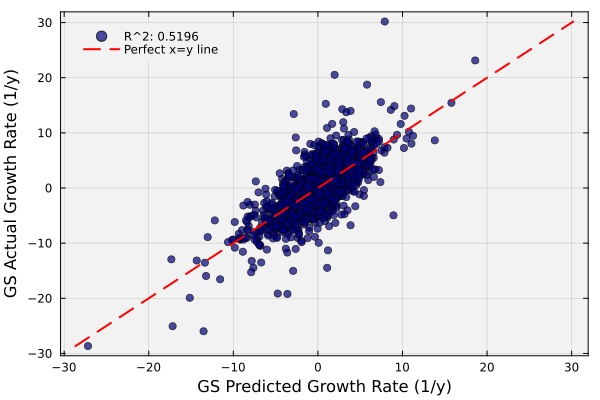

In [45]:
let 

    # initialize -
    parameters = parameters_theory_dict[ticker_of_interest]; # get the parameters for the ticker of interest
    i = findfirst(x-> x== ticker_of_interest, list_of_tickers);  # index of the ticker of interest
    yᵢ = growth_rate_array[:, i];  # get the growth values for ticker
    T = length(yᵢ); # number of time steps
    X̂ = [ones(T) Gₘ]; # design matrix
    θ̂ᵢ = [parameters.alpha; parameters.beta]; # parameter estimates
    ŷᵢ = X̂ * θ̂ᵢ; # predicted values

    # Create x=y line data
    min_val = min(minimum(ŷᵢ), minimum(yᵢ))
    max_val = max(maximum(ŷᵢ), maximum(yᵢ))
    xy_line = [min_val, max_val]

    # plot -
    scatter(ŷᵢ, yᵢ, color = :navy, label="R^2: $(RS |> x-> round(x, digits=4))",
        markersize=4, alpha=0.7, legend=:topleft)
    plot!(xy_line, xy_line, color=:red, linestyle=:dash, lw=2, label="Perfect x=y line")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("$(ticker_of_interest) Predicted Growth Rate (1/y)")
    ylabel!("$(ticker_of_interest) Actual Growth Rate (1/y)")
end

## Task 3: Compute Parameter Uncertainty using Bootstrapping
Fill me in.

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.